In [165]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

### Wczytywanie danych 

In [126]:
df = pd.read_csv('D:/Projektiki/Dannyje/hotel_booking.csv')

In [127]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [129]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [130]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

children         4
country        488
agent        16340
company     112593
dtype: int64


Przyjrzyjmy się również procentowi brakujących wartości

In [131]:
missing_percentage = df.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0])

children     0.003350
country      0.408744
agent       13.686238
company     94.306893
dtype: float64


### Analiza pierwotnych danych oraz ich przygotowanie
Dane zawierają 36 kolumn i 119390 wpisów

* `hotel` -- typ hotelu;
* `is_canceled` -- status anulowania (atrybut docelowy);
* `lead_time` -- czas przed przyjazdem;
* `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number`, `arrival_date_day_of_month` -- data przyjazdu;
* `stays_in_weekend_nights`, `stays_in_week_nights` -- liczba noclegów w weekendy i dni powszednie;
* `adults`, `children`, `babies` -- liczba osób dorosłych, dzieci i niemowląt;
* `meal` -- rodzaj posiłku;
* `country` --  kraj klienta;
* `market_segment` -- segment rynku;
* `distribution_channel` -- kanał dystrybucji;
* `is_repeated_guest` -- stały klient;
* `previous_cancellations`, `previous_bookings_not_cancled` -- liczba wcześniejszych anulowanych i nieodwołanych rezerwacji;
* `reserved_room_type`, `assigned_room_type` -- typ zarezerwowanego i przydzielonego pokoju;
* `booking_changes` -- liczba zmian rezerwacji;
* `deposit_type` -- typ depozytu;
* `agent`, `company` -- identyfikatory agenta i firmy;
* `days_in_waiting_list` -- liczba dni na liście oczekujących;
* `customer_type` -- typ klienta;
* `adr` -- średnia stawka dzienna;
* `required_car_parking_spaces` -- liczba wymaganych miejsc parkingowych;
* `total_of_special_requests` -- całkowita liczba zamówień specjalnych;
* `reservation_status`, `reservation_status_date` -- status rezerwacji i data statusu;

##### W niektórych kolumnach istnieją brakujące wartości
`children`, `country`, `agent`, `company` trzeba dopełnić brakujące wartości

##### Ponadto, aby uprościć proces pracy z danymi, można usunąć niepotrzebne kolumny:
`name`, `email`, `phone-number`, `credit_card`



In [132]:
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Unknown')
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

df = df.drop(columns=['name', 'email', 'phone-number', 'credit_card'])

#### Macierz korelacji cech numerycznych

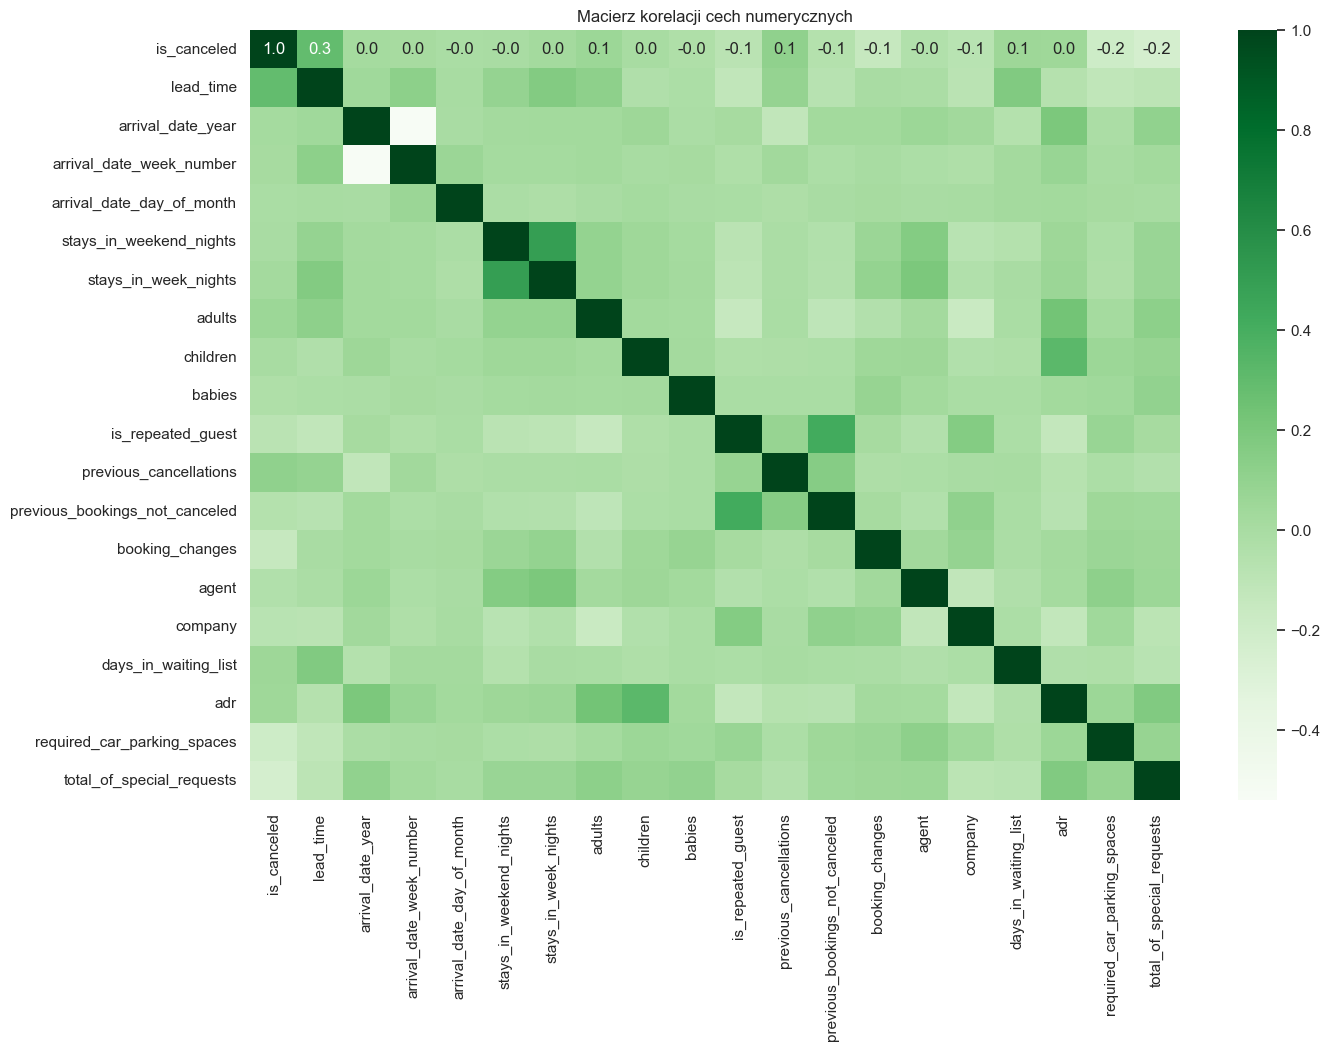

In [133]:
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap="Greens", annot=True, fmt=".1f")
plt.title('Macierz korelacji cech numerycznych')
plt.show()

Nie zaobserwowano żadnych oczywistych korelacji między kolumną docelową a pozostałymi. Zauważalna jest odwrotna korelacja między kolumnami `arrival_date_month` i `arrival_date_year`. Istnieją również znaczące korelacje między kolumną `total_nights` a kolumnami `stays_in_weekend_nights` i `stays_in_week_nights`. Istnieje również znacząca korelacja między kolumnami `previous_bookings_not_cancelled` i `is_repeated_guest`.

Aby wykryć i usunąć wartości odstające w zbiorze danych, użyjemy metody IQR. Metoda ta jest skuteczna w wykrywaniu wartości odstających w danych liczbowych.

Metoda IQR działa w następujący sposób:
* Obliczane są pierwszy (Q1) i trzeci (Q3) kwartyl.
* IQR jest obliczany jako różnica między Q3 i Q1.
* Wartości poniżej Q1 - 1,5 * IQR lub powyżej Q3 + 1,5 * IQR są uważane za emisje.

In [134]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in numeric_columns:
    df = remove_outliers_iqr(df, column)


df.shape

(52806, 32)

Sprawdźmy, czy nie ma duplikatów.

In [135]:
print(len(df[df.duplicated()]))

15215


Usuniemy duplikaty

In [136]:
df = df.drop_duplicates()

In [137]:
df['is_canceled'] = df['is_canceled'].astype(bool)
df['is_repeated_guest'] = df['is_repeated_guest'].astype(bool)

Konwertowanie nazw miesięcy na wartości liczbowe

In [138]:
df['arrival_date_month'] = df['arrival_date_month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})
     

In [139]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

Zmienimy typ danych dla kolumny `children`

In [140]:
df[['children']] = df[['children']].astype('int')

### EDA

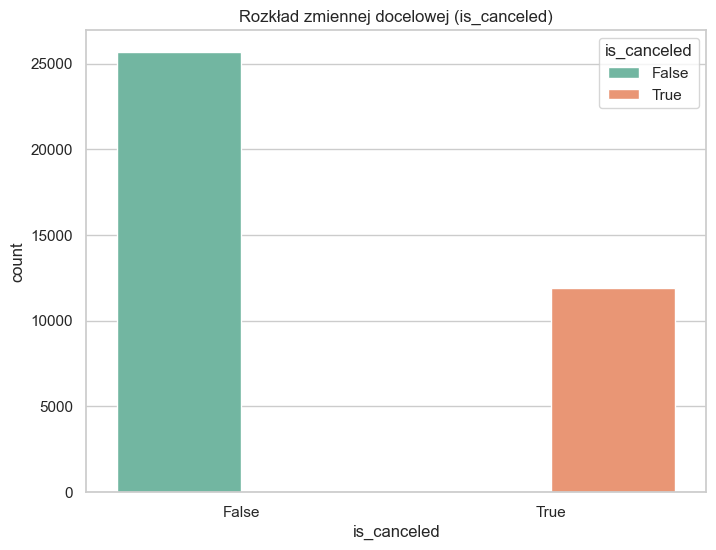

Procent anulowanych rezerwacji: 31.71%


In [141]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_canceled', hue='is_canceled', data=df, palette="Set2")
plt.title('Rozkład zmiennej docelowej (is_canceled)')
plt.show()

cancel_rate = df['is_canceled'].mean() * 100
print(f"Procent anulowanych rezerwacji: {cancel_rate:.2f}%")

Widzimy wyraźny brak równowagi klas w kolumnie `is_canceled` 

*Przyjrzyjmy się rezerwacjom w różnych typach hoteli*

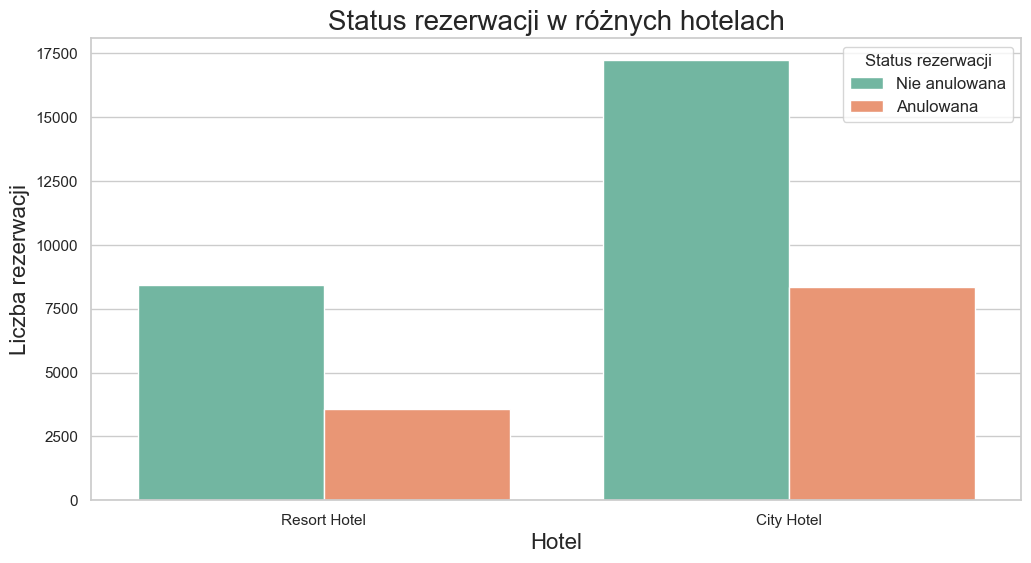

In [142]:
plt.figure(figsize=(12, 6))  

ax1 = sns.countplot(x='hotel', hue='is_canceled', data=df, palette="Set2")

ax1.legend(bbox_to_anchor=(1, 1), title="Status rezerwacji")

plt.title('Status rezerwacji w różnych hotelach', size=20)
plt.xlabel('Hotel', fontsize=16)
plt.ylabel('Liczba rezerwacji', fontsize=16)
plt.legend(['Nie anulowanа', 'Anulowana'], title='Status rezerwacji', fontsize=12)
plt.show()

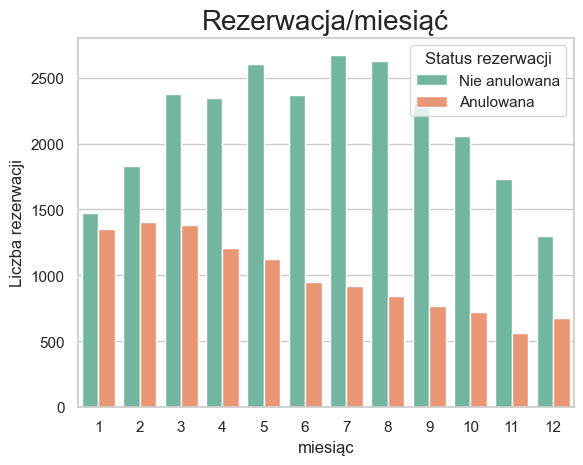

In [143]:
df['month']=df['reservation_status_date'].dt.month
ax1 = sns.countplot(x='month', hue='is_canceled', data= df, palette = 'Set2')
legend_lebels,_ = ax1.get_legend_handles_labels()
plt.title('Rezerwacja/miesiąć', size = 20)
plt.xlabel('miesiąc')
plt.ylabel('Liczba rezerwacji')
plt.legend(['Nie anulowanа','Anulowana'], title='Status rezerwacji')
plt.show()

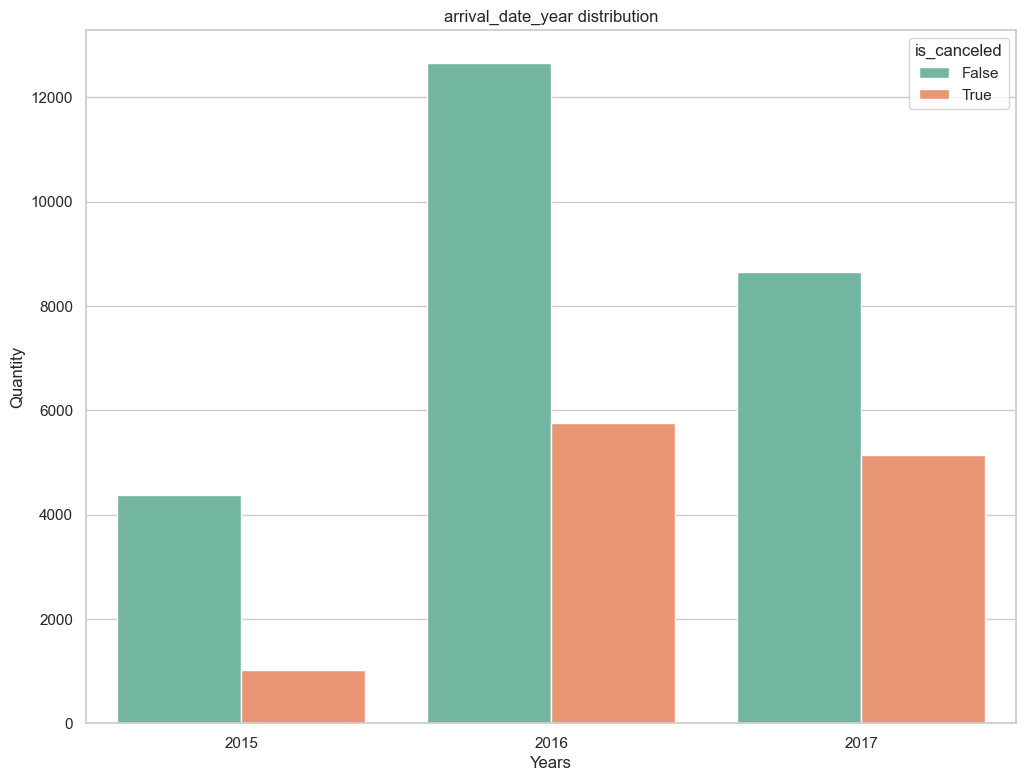

In [144]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 9))
sns.countplot(x='arrival_date_year', hue='is_canceled', data=df, palette = 'Set2')

plt.title('arrival_date_year distribution')
plt.xlabel('Years')
plt.ylabel('Quantity')

plt.show()

In [145]:
print(df['adults'].value_counts())
print(df['children'].value_counts()) 
print(df['babies'].value_counts())

adults
2    37591
Name: count, dtype: int64
children
0    37591
Name: count, dtype: int64
babies
0    37591
Name: count, dtype: int64


Najczęściej rezerwowany jest pokój dla 2 osób dorosłych.

D:\Projektiki\pythonRakuszki\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


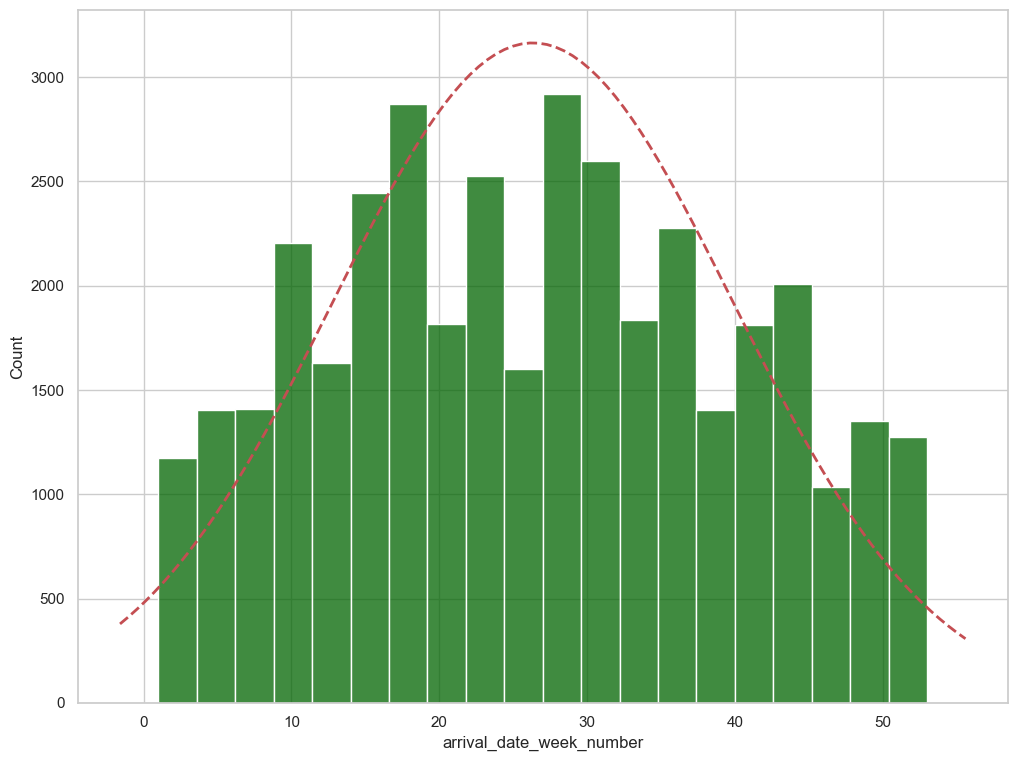

In [146]:
mu = df['arrival_date_week_number'].mean()
std = df['arrival_date_week_number'].std()

plt.figure(figsize=(12, 9))
sns.histplot(df['arrival_date_week_number'], bins=20, color='darkgreen', kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(df['arrival_date_week_number']) * (xmax - xmin) / 20, 'r--', linewidth=2)

plt.show()


Dane w kolumnie `arrival_date_week_number` mają prawie normalny rozkład.

##### Analiza krajów przybycia 
Istnieje wiele krajów z niewielką liczbą odwiedzin w kolumnie `country`, więc zachowajmy 12 krajów i przypiszmy wartość "inne" pozostałym.

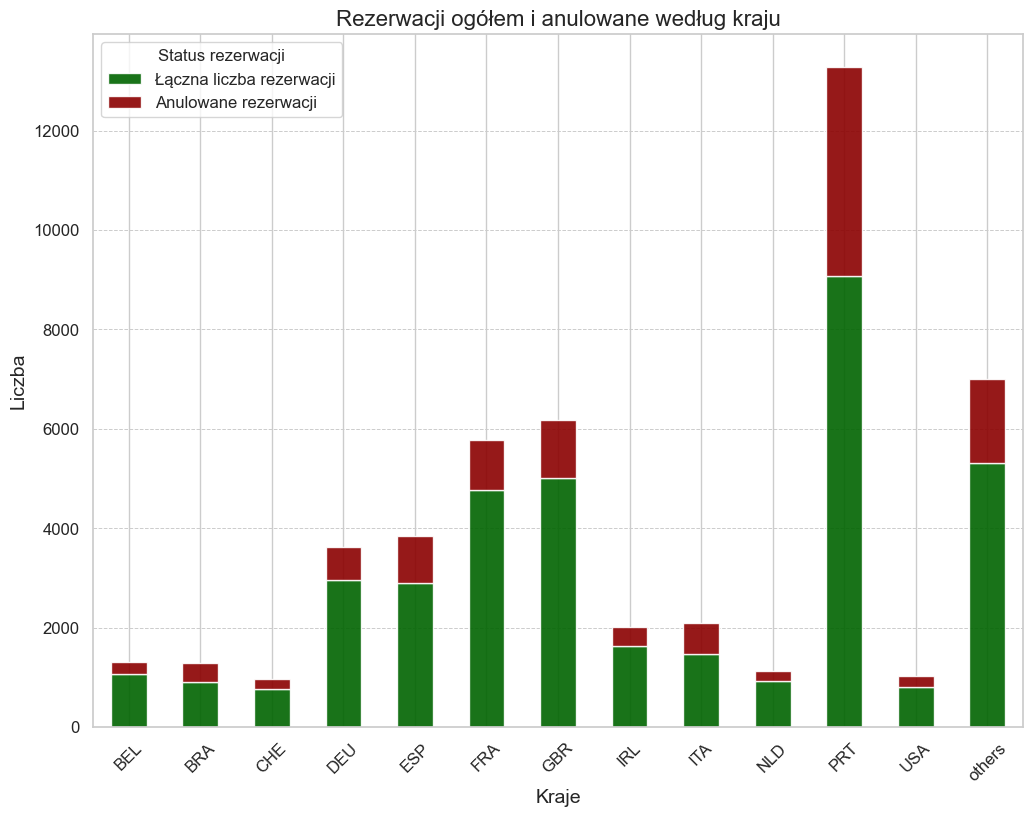

In [147]:
countries = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE']
df['country'] = df['country'].apply(lambda x: 'others' if x not in countries else x)


total_orders = df['country'].value_counts()
canceled_orders = df[df['is_canceled'] == 1]['country'].value_counts()


df_stacked = pd.DataFrame({
    'Łączna liczba rezerwacji': total_orders,
    'Anulowane rezerwacji': canceled_orders
}).fillna(0)


df_stacked.plot(kind='bar', stacked=True, figsize=(12, 9), color=['darkgreen', 'darkred'], alpha=0.9)
plt.title('Rezerwacji ogółem i anulowane według kraju', fontsize=16)
plt.xlabel('Kraje', fontsize=14)
plt.ylabel('Liczba', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Status rezerwacji', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

Widać, że więcej rezerwacji (jak i ich anulowań) pochodzi od klientów z Portugalii

#### Analiza średniej stawki dziennej (adr) w zależności od zmiennych czasowych
Najperw przyjrzyjmy się zależności od miesiąca przybycia:

D:\Projektiki\pythonRakuszki\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Projektiki\pythonRakuszki\.venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Projektiki\pythonRakuszki\.venv\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Projektiki\pythonRakuszki\.venv\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 l

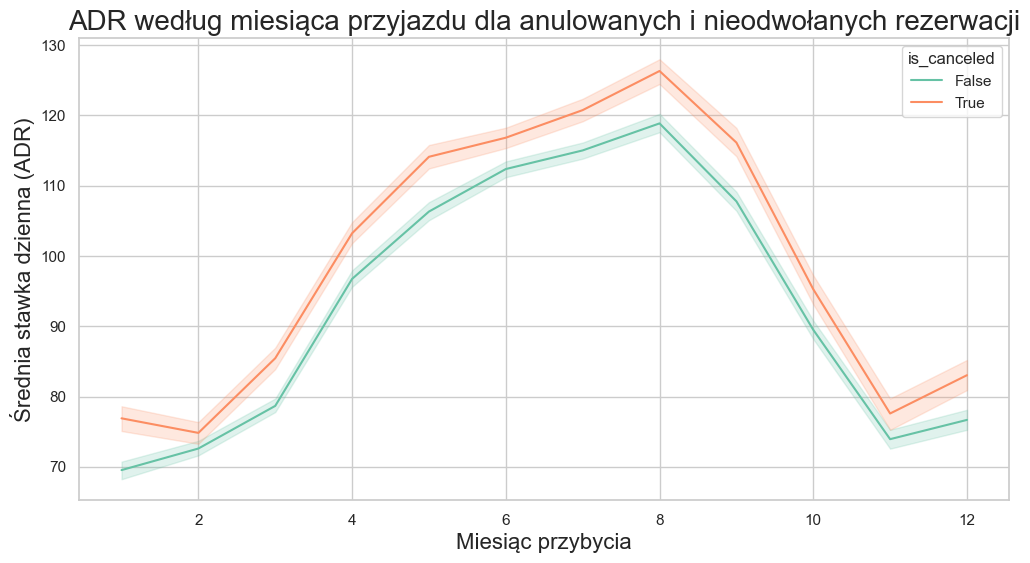

In [148]:
plt.figure(figsize=(12, 6))

sns.lineplot(x='arrival_date_month', y='adr', hue='is_canceled', data=df, palette="Set2")

plt.title('ADR według miesiąca przyjazdu dla anulowanych i nieodwołanych rezerwacji', size=20)
plt.xlabel('Miesiąc przybycia', fontsize=16)
plt.ylabel('Średnia stawka dzienna (ADR)', fontsize=16)

plt.show()

1) *Średnia stawka dzienna (ADR)*:
    * Anulowane rezerwacje (pomarańczowa linia): W większości miesięcy średnia stawka dzienna jest wyższa w przypadku anulowanych rezerwacji w porównaniu z rezerwacjami nieodwołanymi.
    * Nieanulowane rezerwacje (zielona linia): Zwykle mają niższe średnie stawki dzienne.
2) *Wahania sezonowe*:
    * Oba rodzaje rezerwacji wykazują sezonowe wahania średniej stawki dziennej.
    * ADR rośnie od początku roku do lata (czerwiec-sierpień), a następnie spada pod koniec roku.
    * Średnia dzienna stawka jest najwyższa w lipcu i sierpniu dla obu typów rezerwacji.
3) *Różnica między anulowanymi i nieodwołanymi rezerwacjami*:
    * Różnica w średniej dziennej stawce między anulowanymi i nieodwołanymi rezerwacjami jest najbardziej widoczna między kwietniem a październikiem, kiedy ADR dla anulowanych rezerwacji jest znacznie wyższy.
    * Różnica jest mniejsza na początku i na końcu roku, ale ADR jest nadal wyższy w przypadku anulowanych rezerwacji.
Z tego możeny wnioskować, że:
    * Wysoka średnia stawka dzienna (ADR) koreluje z wyższym prawdopodobieństwem anulowania rezerwacji. Widać to po tym, że w okresach z wyższymi ADR liczba anulowanych rezerwacji jest również wyższa.
    * Wahania sezonowe wpływają na ADR i prawdopodobieństwo anulowania rezerwacji. Latem (w szczycie sezonu) średnia dzienna stawka jest wyższa, a co za tym idzie, liczba anulowanych rezerwacji jest wyższa.

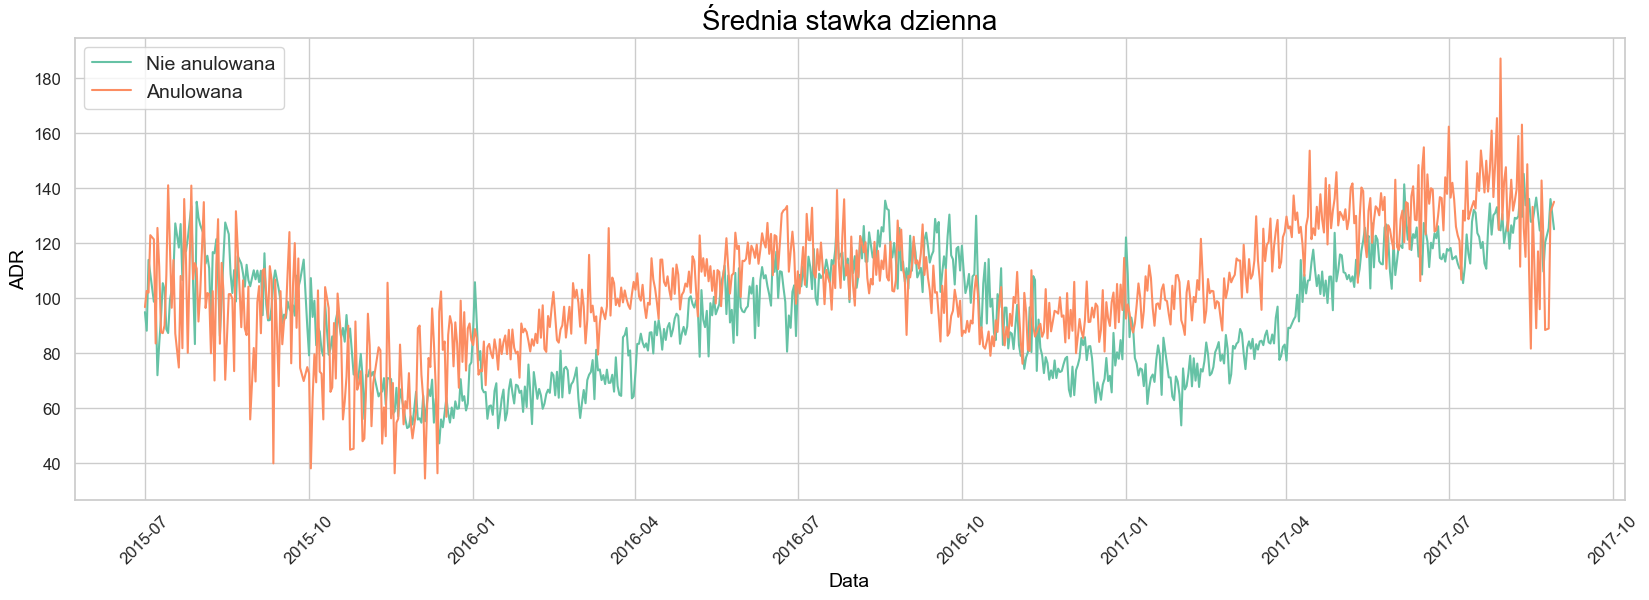

In [149]:
cancelled_data = df[df['is_canceled'] == 1]
cancelled_df_adr = cancelled_data.groupby('reservation_status_date')[['adr']].mean()
cancelled_df_adr.reset_index(inplace=True)
cancelled_df_adr.sort_values('reservation_status_date', inplace=True)

not_cancelled_data = df[df['is_canceled'] == 0]
not_cancelled_df_adr = not_cancelled_data.groupby('reservation_status_date')[['adr']].mean()
not_cancelled_df_adr.reset_index(inplace=True)
not_cancelled_df_adr.sort_values('reservation_status_date', inplace=True)


common_dates = pd.merge(cancelled_df_adr[['reservation_status_date']], not_cancelled_df_adr[['reservation_status_date']], on='reservation_status_date')


cancelled_df_adr = cancelled_df_adr[cancelled_df_adr['reservation_status_date'].isin(common_dates['reservation_status_date'])]
not_cancelled_df_adr = not_cancelled_df_adr[not_cancelled_df_adr['reservation_status_date'].isin(common_dates['reservation_status_date'])]


plt.figure(figsize=(20, 6))
plt.plot(not_cancelled_df_adr['reservation_status_date'], not_cancelled_df_adr['adr'], label='Nie anulowana', color='#66c2a5')
plt.plot(cancelled_df_adr['reservation_status_date'], cancelled_df_adr['adr'], label='Anulowana', color='#fc8d62')
plt.title('Średnia stawka dzienna', fontsize=20, color="Black")
plt.xlabel('Data', fontsize=14, color="Black")
plt.ylabel('ADR', fontsize=14, color="Black")
plt.legend(fontsize=14)

# Ustawianie etykiet osi x dla co trzeciego miesiąca
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


Ogólnie rzecz biorąc, anulowane rezerwacje (pomarańczowa linia) mają zazwyczaj wyższe średnie stawki dzienne w porównaniu do nieodwołanych rezerwacji (zielona linia). Potwierdza to hipotezę, że rezerwacje są częściej anulowane, gdy średnia dzienna stawka jest wyższa. Obserwujemy sezonowe wahania ADR, które mogą być związane z wysokimi i niskimi sezonami w branży hotelarskiej. Na przykład szczyty pod koniec 2016 i 2017 roku.
Ten wykres pomaga wizualnie potwierdzić założenie, że prawdopodobieństwo anulowania wzrasta wraz z wyższymi średnimi stawkami dziennymi

##### Pokażmy rozkład atrybutów kategorycznych, które nie są jeszcze reprezentowane

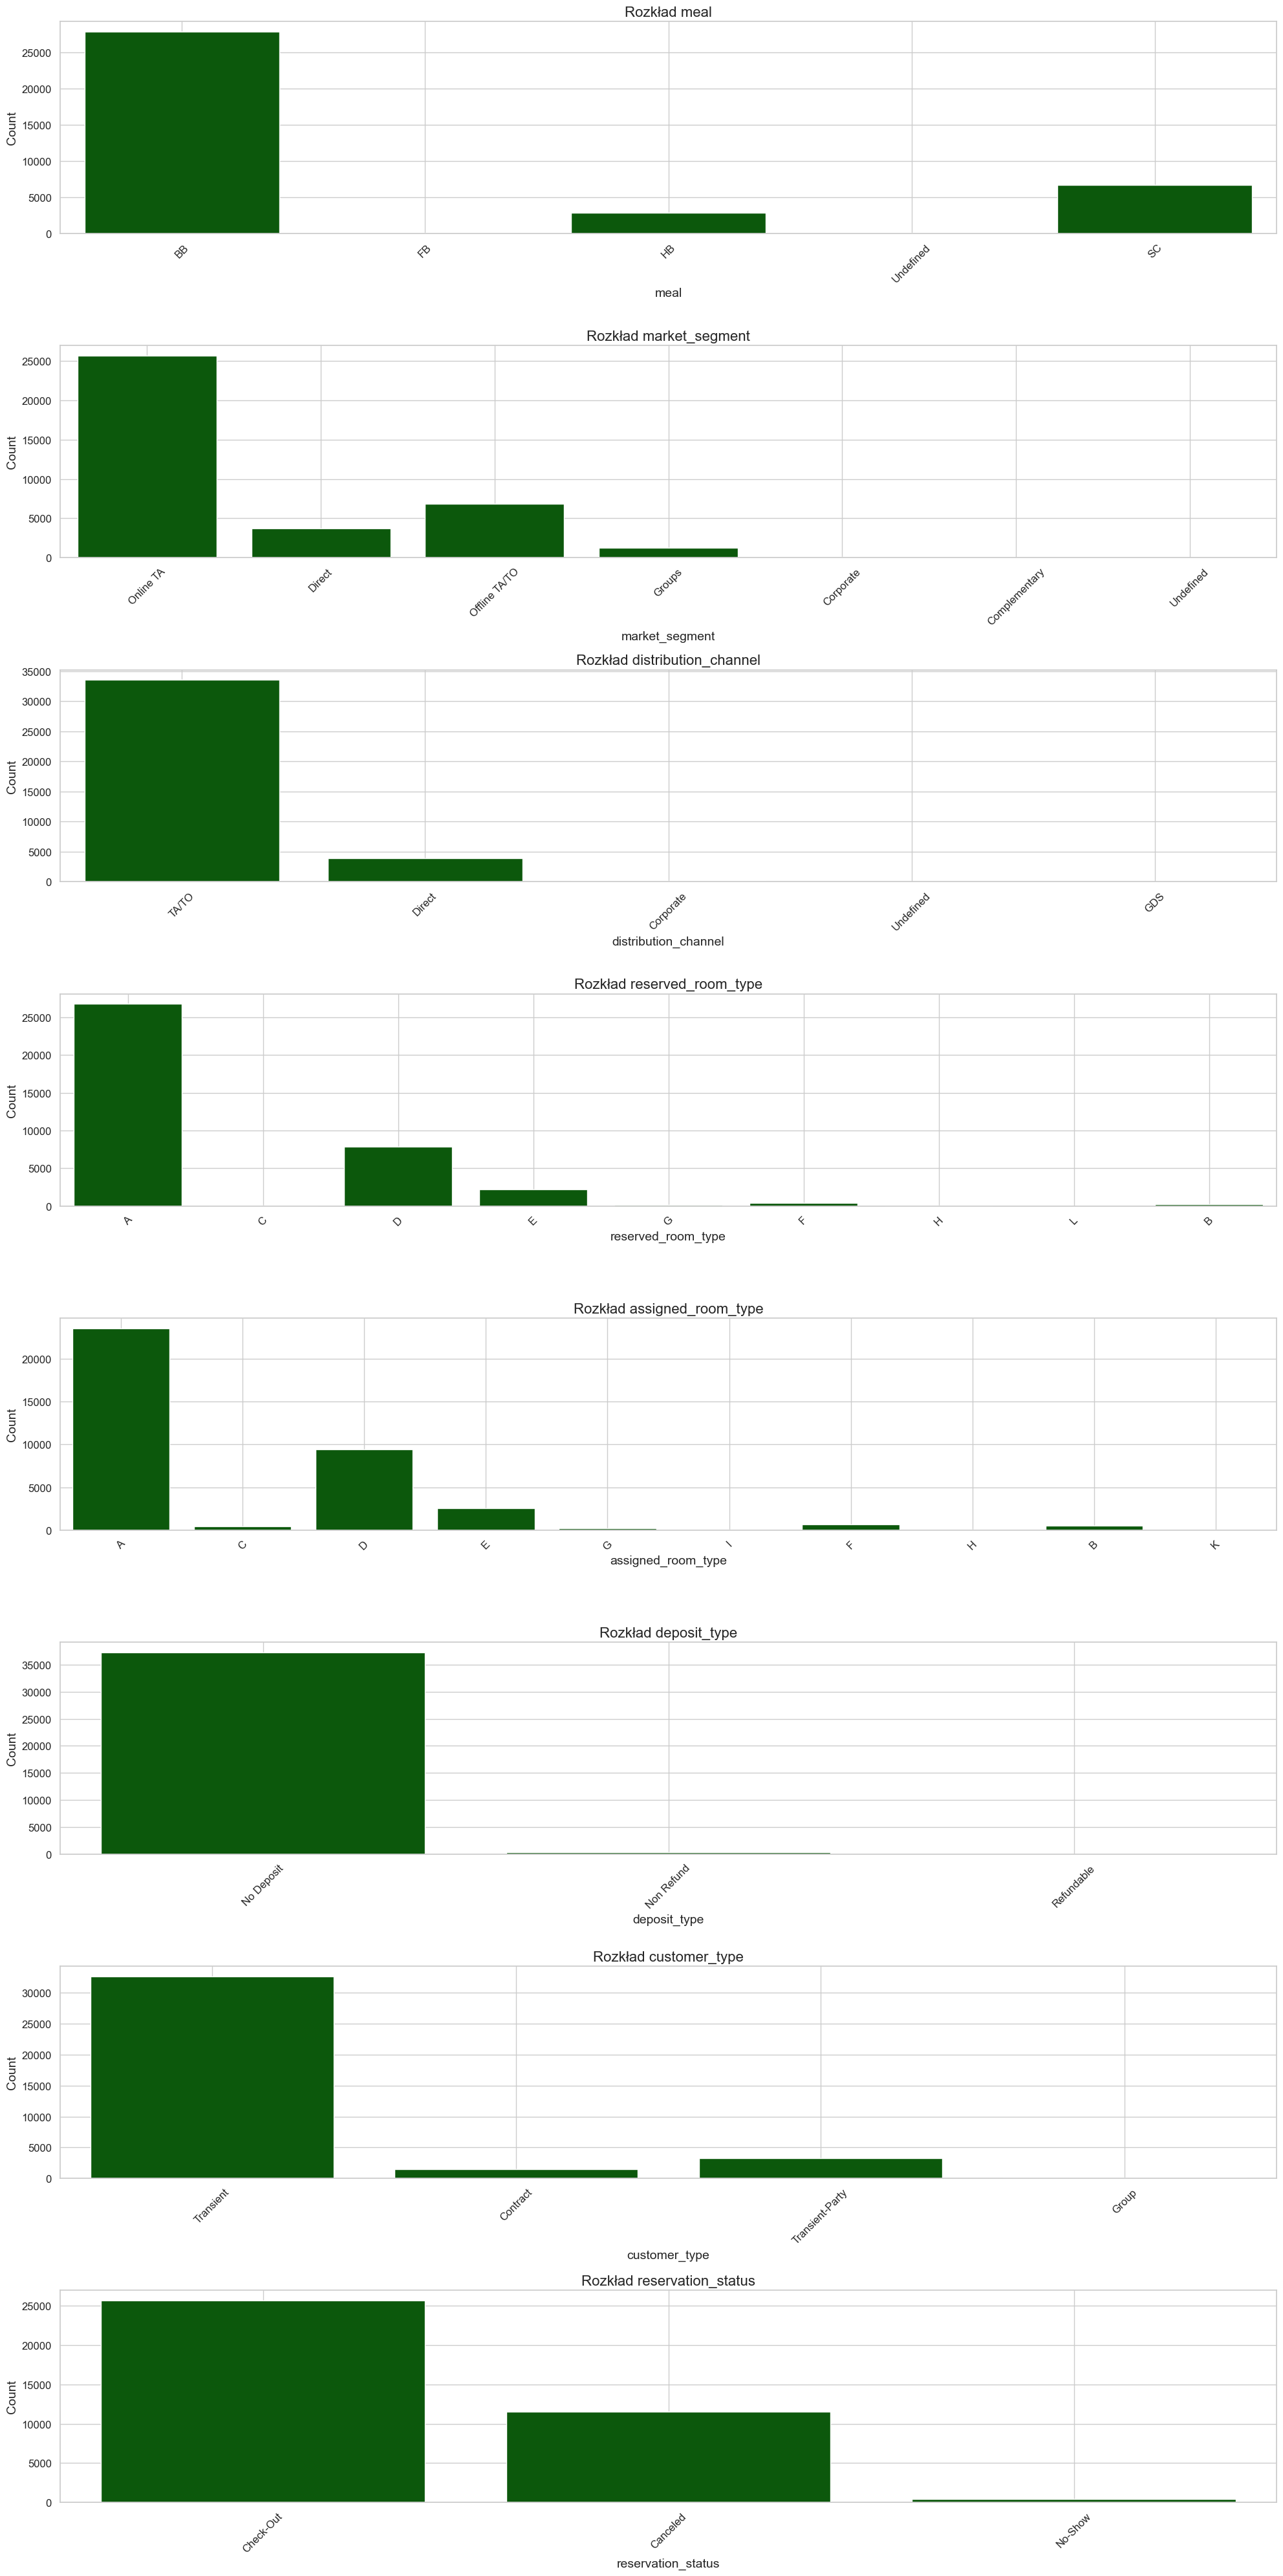

In [150]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop(['hotel', 'country'])

plt.figure(figsize=(20, len(categorical_features) * 5))

for i, col in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(data=df, x=col, color='darkgreen')
    plt.title(f'Rozkład {col}', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

### Przejdźmy do stworzenia modelu określającego prawdopodobieństwo anulowania rezerwacji

Aby pracować z atrybutami kategorycznymi, zastosujmy do nich technologię One-Hot Encoding, aby modele działały poprawnie. Usuwamy kolumne, które nie będą używane do szkolenia modelu

In [151]:
X = df.drop(columns=['is_canceled', 'reservation_status', 'reservation_status_date'])
X = pd.get_dummies(X, drop_first=True)
y = df['is_canceled']

Podział danych na próbki treningowe (80%) i testowe (20%).

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standaryzujemy dane dla lepszej wydajności modeli

In [153]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Tworzymy własny model
Model ma dwie warstwy ukryte z aktywacją ReLU i jedną warstwę wyjściową z aktywacją sigmoidalną.

In [154]:
model_tf = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])


model_tf.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model_tf.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
752/752 [==============================] - 5s 7ms/step - loss: 0.4871 - accuracy: 0.7584 - val_loss: 0.4358 - val_accuracy: 0.7905
Epoch 2/10
752/752 [==============================] - 5s 6ms/step - loss: 0.3824 - accuracy: 0.8346 - val_loss: 0.3416 - val_accuracy: 0.8630
Epoch 3/10
752/752 [==============================] - 5s 6ms/step - loss: 0.2956 - accuracy: 0.8834 - val_loss: 0.2801 - val_accuracy: 0.8874
Epoch 4/10
752/752 [==============================] - 5s 6ms/step - loss: 0.2493 - accuracy: 0.9013 - val_loss: 0.2556 - val_accuracy: 0.8919
Epoch 5/10
752/752 [==============================] - 5s 6ms/step - loss: 0.2272 - accuracy: 0.9091 - val_loss: 0.2295 - val_accuracy: 0.9076
Epoch 6/10
752/752 [==============================] - 5s 6ms/step - loss: 0.2141 - accuracy: 0.9134 - val_loss: 0.2433 - val_accuracy: 0.9094
Epoch 7/10
752/752 [==============================] - 5s 7ms/step - loss: 0.2081 - accuracy: 0.9169 - val_loss: 0.2213 - val_accuracy: 0.9144
Epoch 

Ocena dokładności modelu na danych testowych

In [155]:
tf_loss, tf_accuracy = model_tf.evaluate(X_test_scaled, y_test)
print(f"TensorFlow Model Accuracy: {tf_accuracy}")

235/235 [==============================] - 1s 3ms/step - loss: 0.2201 - accuracy: 0.9133
TensorFlow Model Accuracy: 0.9132863283157349


Wykres pokazuje zmianę funkcji straty podczas fazy szkolenia i walidacji.

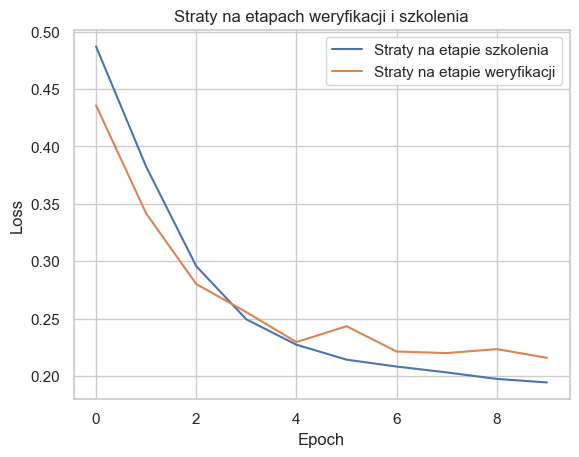

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Straty na etapach weryfikacji i szkolenia')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Straty na etapie szkolenia', 'Straty na etapie weryfikacji'], loc='upper right')
plt.show()

Tworzenie i szkolenie modelu regresji logistycznej

In [157]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Model Accuracy: {lr_accuracy}")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Model Accuracy: 0.7547546216252161
[[4580  552]
 [1292 1095]]
              precision    recall  f1-score   support

       False       0.78      0.89      0.83      5132
        True       0.66      0.46      0.54      2387

    accuracy                           0.75      7519
   macro avg       0.72      0.68      0.69      7519
weighted avg       0.74      0.75      0.74      7519


Oceniamy jej dokładność i uzyskajmy wskaźniki jakości.

Tworzenie i szkolenie modelu XGBoost

In [158]:
model_xgb = XGBClassifier(eval_metric='logloss')
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {xgb_accuracy}")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Model Accuracy: 0.9296448995877111
[[5034   98]
 [ 431 1956]]
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      5132
        True       0.95      0.82      0.88      2387

    accuracy                           0.93      7519
   macro avg       0.94      0.90      0.92      7519
weighted avg       0.93      0.93      0.93      7519


Porównanie modeli

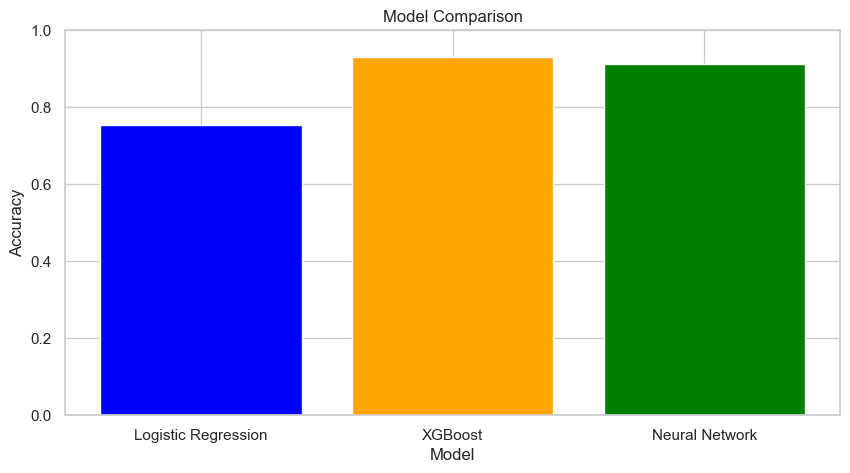

In [159]:
models = ['Logistic Regression', 'XGBoost', 'Neural Network']
accuracies = [lr_accuracy, xgb_accuracy, tf_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.show()

Wizualizacja krzywej ROC dla wszystkich modeli

In [160]:
y_prob_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)


y_prob_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


y_prob_tf = model_tf.predict(X_test_scaled).ravel()
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_prob_tf)
roc_auc_tf = auc(fpr_tf, tpr_tf)

235/235 [==============================] - 0s 2ms/step


In [161]:
print(roc_auc_lr)
print(roc_auc_xgb)
print(roc_auc_tf)

0.8124483472929654
0.9707062008717654
0.9552583884322753


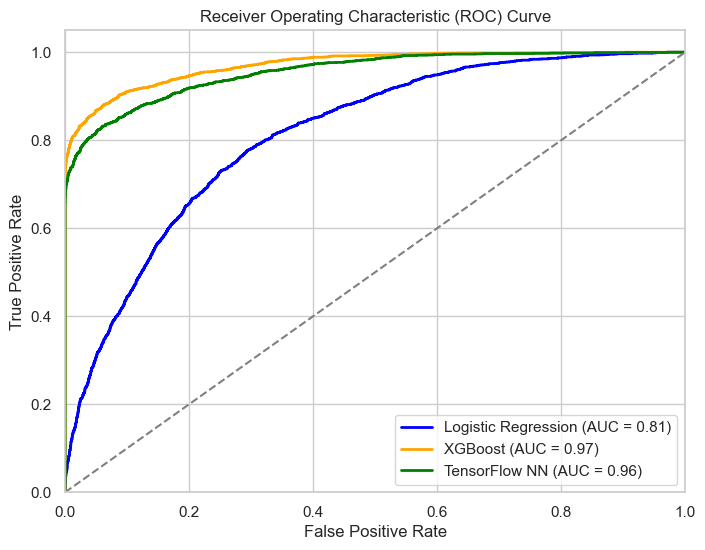

In [162]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_tf, tpr_tf, color='green', lw=2, label=f'TensorFlow NN (AUC = {roc_auc_tf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Wykres krzywej ROC pokazuje jakość klasyfikacji modelu na podstawie pola pod krzywą (AUC)

Model regresji logistycznej:
* Accuracy: 0,7548
* ROC-AUC: 0,8124

Model XGBoost:
* Accuracy: 0,9296
* ROC-AUC: 0,9707

Model własny:
* Accuracy: 0,9140
* ROC-AUC: 0,9552

Spośród wszystkich modeli, model XGBoost wykazał najwyższą dokładność (92,96%) i największy obszar pod krzywą ROC (AUC = 0,9707), co wskazuje na jego wyższość w klasyfikacji. Model sieci neuronowej TensorFlow również wykazał wysoką dokładność (91,40%) i dobre AUC (0,9559). Model regresji logistycznej był mniej dokładny w porównaniu z innymi (75,48%) z AUC = 0,8124.

Spróbujmy polepszyć wydajność modeli XGB
Definiuje siatkę hiperparametrów (param_grid), którą chcemy skonfigurować:

`n_estimators`: Liczba drzew w modelu (100, 200, 300).
`max_depth`: Maksymalna głębokość każdego drzewa (3, 4, 5).
`learning_rate`: współczynnik uczenia się modelu (0.01, 0.1, 0.2).
`subsample`: Proporcja losowych próbek z próbki szkoleniowej dla każdego drzewa (0.8, 0.9, 1.0).

In [163]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss'), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated score: {grid_search.best_score_}")

best_model_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_model_xgb.predict(X_test_scaled)
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
print(f"Optimized XGBoost Model Accuracy: {best_xgb_accuracy}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validated score: 0.9262436818302741
Optimized XGBoost Model Accuracy: 0.9312408564968746


 Po ustaleniu hiperparametrów model jest następnie oceniany na próbce testowej, aby sprawdzić, jak dobrze radzi sobie z nowymi danymi. W tym przypadku dokładność zoptymalizowanego modelu XGBoost wynosi 93,12%

In [164]:
new_data = {
    'lead_time': [100],
    'arrival_date_year': [2017],
    'arrival_date_month': ['August'],
    'arrival_date_week_number': [12],
    'arrival_date_day_of_month': [14],
    'stays_in_weekend_nights': [2],
    'stays_in_week_nights': [5],
    'adults': [0],
    'children': [2],
    'babies': [0],
    'meal': ['BB'],
    'country': ['USA'],
    'market_segment': ['Direct'],
    'distribution_channel': ['Direct'],
    'is_repeated_guest': [1],
    'previous_cancellations': [0],
    'previous_bookings_not_canceled': [0],
    'reserved_room_type': ['A'],
    'assigned_room_type': ['A'],
    'booking_changes': [0],
    'deposit_type': ['No Deposit'],
    'agent': ['NULL'],
    'company': ['NULL'],
    'days_in_waiting_list': [0],
    'customer_type': ['Transient'],
    'adr': [100.0],
    'required_car_parking_spaces': [0],
    'total_of_special_requests': [1]
}

new_df = pd.DataFrame(new_data)


new_df = pd.get_dummies(new_df, drop_first=True)

# Убедитесь, что все признаки соответствуют тренировочным данным
missing_cols = set(X.columns) - set(new_df.columns)
for col in missing_cols:
    new_df[col] = 0

new_df = new_df[X.columns]


new_df_scaled = scaler.transform(new_df)


prediction = best_model_xgb.predict(new_df_scaled)
probability = best_model_xgb.predict_proba(new_df_scaled)[:, 1]

print(f"Prediction: {prediction[0]}")
print(f"Probability of cancellation: {probability[0]}")

Prediction: 0
Probability of cancellation: 0.44317445158958435
